# 方法准备

In [1]:
#woe function and replace
def WOE(X,Y):
    import pandas as pd
    import numpy as np
    cross = pd.crosstab(X,Y)
    cross['all'] = cross[0] + cross[1]
    # y0 -- 全部未违约
    # y1 -- 全部违约
    y0 = np.sum(cross[0])
    y1 = np.sum(cross[1])
    cross['py0'] = cross[0]*1.0/y0
    cross['py1'] = cross[1]*1.0/y1
    cross['WOE'] = np.log((cross['py1'] + 0.0001)*1.0 / (cross['py0'] + 0.0001))
    cross['IV'] = (cross['py1']-cross['py0']) * cross['WOE']
    cross['Gini'] = cross[0] * 1.0 / cross['all'] * (1-cross[0]*1.0/cross['all']) * 2
    WOE_value = np.sum(cross['WOE'])
    IV_value = np.sum(cross['IV'])
    return cross , WOE_value, IV_value

# WOE_replace
# X是特征名称，bins是切分区间, data原始数据框，data_woe作WOE变换数据框，cross交叉表
def WOE_replace(X, bins, cross, data = train, data_woe = train_woe):
    import pandas as pd
    WOE_replace = cross['WOE'].to_dict()
    data_woe[X] = pd.cut(data[X],bins = bins,right=False).map(WOE_replace)

NameError: name 'train' is not defined

In [2]:
# 方差膨胀系数
# x 训练数据（一列）   y 标签
def VIF(x,y):
    import statsmodels.api as sm
    name = y.name
    x = x.as_matrix()
    X = sm.add_constant(x)
    y = y.as_matrix()
    model = sm.OLS(y,X)
    results = model.fit()
    print '变量名：%s , r^2 为 ：%.4f , VIF为 : %.4f' % (name, results.rsquared,(1 - results.rsquared**2))
    print '参数值 ：',results.params
    print 'p - value ：',results.pvalues

# 所有data分别计算VIF
def feature_VIF(data):
    for feature in data.columns:
        x = data.ix[:,data.columns != feature]
        y = data.ix[:,feature]
        VIF(x,y)

TP: 14 , FP: 27 , TN: 45 , FN: 14
precision:  34.146% 
recall:  50.000%
lift : 1.21951
KS-VALUE : 13.09524% , ks-threshold : 0.55123 , ks-threshold-count: 36


,index,predict,actual,bad_rate,good_rate,bad_rate_cum,good_rate_cum,ks
0,68,0.969305,1,0.035714,0.000000,0.035714,0.000000,0.035714
1,27,0.951996,1,0.035714,0.000000,0.071429,0.000000,0.071429
2,64,0.951812,0,0.000000,0.013889,0.071429,0.013889,0.057540
3,73,0.940429,0,0.000000,0.013889,0.071429,0.027778,0.043651
4,17,0.932216,0,0.000000,0.013889,0.071429,0.041667,0.029762


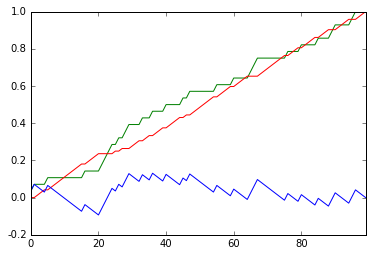

In [14]:
#　包括混淆矩阵、命中召回、f-value、ks-value、curve
# threshold > 1，则为报警个数， < 1则为分数阈值
# bins为将分数分为几段，0段则为全样本的每个分一段
# cons 为 预测 - predict 和实际标签 - actual
# capital_loss 是否统计资损
# green为正样本，red为负样本，blue为KS-curve
def showMe(threshold, bins, cons, capital_loss):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from IPython.display import display
    from collections import defaultdict
    %matplotlib inline
    
    if threshold >= 1:
#         threshold = cons.ix[np.argsort(cons.predict.values)[::-1][threshold-1],:]['predict']
        cons = cons.reset_index()
        threshold = cons.ix[np.argsort(cons.predict.values)[::-1][threshold-1],'predict']
    
#     tuijian = defaultdict(str)
#     for idx, rows in cons.ix[cons['predict'] >= threshold,['ECIF_CUST_ID','KJRQ']].iterrows():
#         tuijian[rows] = 1
# #         cons['judge'] = cons['ECIF_CUST_ID'].map
#     cons2 = cons.groupby(['ECIF_CUST_ID','judge'])

    TP = cons[((cons.predict >= threshold) & (cons.actual == 1))].shape[0]
    FP = cons[((cons.predict >= threshold) & (cons.actual == 0))].shape[0]
    TN = cons[((cons.predict < threshold) & (cons.actual == 0))].shape[0]
    FN = cons[((cons.predict < threshold) & (cons.actual == 1))].shape[0]
    print 'TP: %d , FP: %d , TN: %d , FN: %d'% (TP,FP,TN,FN)
    
    if capital_loss:
        missing_amount = np.sum(cons.ix[((cons.predict >= threshold) & (cons.actual == 1)),'amount'])
        all_amount = np.sum(cons.ix[:,'amount'])
        print 'capital loss = %.2f ' % (missing_amount * 1.0 / all_amount)
    # 如果需要阈值敏感的评价指标，在这里可以添加

    precision = TP * 1.0/( TP + FP)
    recall = TP * 1.0 / (TP + FN)
    print 'precision:  %.3f%% \nrecall:  %.3f%%' % (precision*100 , recall*100)
    F_value = 5*TP * 1.0 / ( 5*TP + 4*FN + FP )
    lift = precision / ((TP+FN)*1.0/len(cons))
    print 'lift : %.5f' % (lift)

    # 计算KS，不按照bins组分段，KS结果应该优于分段结果
    if bins == 0:

        cons = cons.sort_values('predict',ascending = False)
#         cons = cons.reset_index()
        cons = cons.reset_index(range(len(cons)))

        cons['bad_rate'] = cons.actual * 1.0 / (TP + FN)
        cons['good_rate'] = (1 - cons.actual) * 1.0 / (TN + FP)
        
        cons['bad_rate_cum'] = cons['bad_rate'].cumsum()
        cons['good_rate_cum'] = cons['good_rate'].cumsum()
        cons['ks'] = cons['bad_rate_cum'] - cons['good_rate_cum']
        
        print 'KS-VALUE : %.5f%% , ks-threshold : %.5f , ks-threshold-count: %d'% (np.max(cons.ks * 100),\
                                                                                   cons.ix[np.argmax(cons.ks * 100),'predict'],np.argmax(cons.ks * 100))
        display(cons.head(5))
        cons['bad_rate_cum'].plot(kind = 'line',color = 'g')
        cons['good_rate_cum'].plot(kind = 'line',color = 'r')
        (cons['bad_rate_cum'] - cons['good_rate_cum']).plot(kind = 'line',color = 'blue')
    # 分段后作KS，取决于客户需要
    else:
        cons = cons.sort_values(['predict'],ascending=False)
#         cons = cons.reset_index()
#         cons = cons.reset_index(range(len(cons)))
    
        cons['area'] = range(len(cons))
        bins = [bins*i for i in range(len(cons)/bins)]
        cons['area'] = pd.cut(cons.area,bins = bins,labels = range(1, len(bins), 1),retbins = False)

        group_cons = pd.DataFrame(cons.groupby('area')['actual'].sum())
        group_cons['bad_rate'] = group_cons.actual * 1.0 / (TP + FN)
        group_cons['good_rate'] = (len(cons)*1.0/len(bins) - group_cons.actual) * 1.0 / (TN + FP)

        group_cons['bad_rate_cum'] = group_cons['bad_rate'].cumsum()
        group_cons['good_rate_cum'] = group_cons['good_rate'].cumsum()
        group_cons['ks'] = group_cons['bad_rate_cum'] - group_cons['good_rate_cum']
        insertRow = pd.DataFrame([[0,0,0,0,0,0]],columns=group_cons.columns)
        group_cons = insertRow.append(group_cons,ignore_index = True)
        print 'KS-VALUE : %.5f%% , location : %d'% (np.max(group_cons.ks * 100), np.argmax(group_cons.ks * 100))
        group_cons['bad_rate_cum'].plot(kind = 'line',color = 'g')
        group_cons['good_rate_cum'].plot(kind = 'line',color = 'r')
        group_cons['ks'].plot(kind = 'line',color = 'blue')
        
        cut = cons.groupby(['area']).agg({'actual':np.sum,'predict':np.size})
        cut['precision'] = cut['actual']*1.0/cut['predict']
        cut['precision2'] = (cut['actual'].cumsum()*1.0/cut['predict'].cumsum())
        cut['recall'] = cut['actual']*1.0/ np.sum(cut['actual'])    
        cut['recall2'] = cut['recall'].cumsum()
        cut['lift'] = cut['precision']*1.0 / ((TP+FN)*1.0/len(cons))
        cut['lift2'] =  cut['precision2'] / ((TP+FN)*1.0/len(cons))
        display(cut.head(24))
        
#         cut_1 = cons.head(100000)
#         cut_1['area'] = range(len(cut_1))
#         cut_1['area'] = pd.cut(cut_1.area,bins = 20,labels = range(1, 20 + 1, 1),retbins = False)
        
#         cut = cut_1.groupby(['area']).agg({'actual':np.sum,'predict':np.size})
#         cut['precision'] = cut['actual']*1.0/cut['predict']
#         cut['precision2'] = (cut['actual'].cumsum()*1.0/cut['predict'].cumsum())
#         cut['recall'] = cut['actual']*1.0/ np.sum(cut['actual'])    
#         cut['recall2'] = cut['recall'].cumsum()
#         cut['lift'] = cut['precision']*1.0 / ((TP+FN)*1.0/len(cons))
#         cut['lift2'] =  cut['precision2'] / ((TP+FN)*1.0/len(cons))
#         display(cut.head(10))
#         print cut_1.shape
        
        
        
#         cut_1 = cons.head(10000)
#         cut_1['area'] = range(len(cut_1))
#         cut_1['area'] = pd.cut(cut_1.area,bins = 20,labels = range(1, 20 + 1, 1),retbins = False)
        
#         cut = cut_1.groupby(['area']).agg({'actual':np.sum,'predict':np.size})
#         cut['precision'] = cut['actual']*1.0/cut['predict']
#         cut['precision2'] = (cut['actual'].cumsum()*1.0/cut['predict'].cumsum())
#         cut['recall'] = cut['actual']*1.0/ np.sum(cut['actual'])    
#         cut['recall2'] = cut['recall'].cumsum()
#         cut['lift'] = cut['precision']*1.0 / ((TP+FN)*1.0/len(cons))
#         cut['lift2'] =  cut['precision2'] / ((TP+FN)*1.0/len(cons))
#         display(cut.head(20))
        
# 可以测试一下 
import numpy as np
import pandas as pd
n = 100
y  = np.random.binomial(1, 0.3, n)
x = np.random.random(n)
z = np.append(x,y)
z = z.reshape(2,100)
cons = pd.DataFrame(z.T, columns=['predict','actual'])
threshold = 0.5
threshold2 = 52
bins = 0
showMe(threshold, bins, cons, 0)

In [119]:
# bins 分段，分为几段
# ori 和 pred 为两个list 
def PSI(bins, ori, pred):
    import pandas as pd
    import numpy as np
    # ori - 预期占比 - 训练集， pred - 实际占比 - 测试集
    save ,to_cut = pd.qcut(ori,q = bins,retbins = True)
    t1 = pd.DataFrame(pd.qcut(ori,q = bins, labels = range(10)).value_counts())
    to_cut = np.sort(np.append([0,1],to_cut[1:10],axis= 0))
    t2 = pd.DataFrame(pd.cut(pred,bins = to_cut, labels = range(10)).value_counts())
    cons = t1.merge(t2,right_index = True, left_index = True)
    cons.columns = ['ori_sum','pred_sum']
    cons['ori_rate'] = cons.ori_sum * 1.0 / np.sum(cons.ori_sum)
    cons['pred_rate'] = cons.pred_sum * 1.0 / np.sum(cons.pred_sum)
    psi_value = np.sum((cons.pred_rate - cons.ori_rate) * np.log(cons.pred_rate*1.0 / cons.ori_rate))
#     print cons
    print 'psi_value : %.5f%%' % (psi_value * 100)

In [ ]:
# clf是sklearn中rf，gbm的分类器
# data是训练数据 X  （df）
def feature_imp(data, clf):
    importance = clf.feature_importances_
    indices = np.argsort(clf.feature_importances_)[::-1]
    col_list = data.columns
    for f in range(data.shape[1]):
        print '%d. feature %d (%f) (name= %s )'% (f +1, indices[f], importance[indices[f]] ,col_list[indices[f]])

In [ ]:
# 读取大数据集的方法
path = '/opt/app/bsfit/oridata/'
reader = pd.read_csv(path + 'ym2.csv', iterator=True)
loop = True
chunkSize = 100000
chunks = []
i = 1
while loop:
    try:
        print i
        i += 1
        chunk = reader.get_chunk(chunkSize)
        # 在这里可以做数据清洗的操作
#          ----------
        chunks.append(chunk)
    except StopIteration:
        loop = False
        print "Iteration is stopped."
df = pd.concat(chunks, ignore_index=True)

In [ ]:
# spark版本调用数据服务
# 返回spark 的df，df可以再注册为table
# data - 需要读取的spark - df
# area - 需要查询的数据，是一个list - province ， city
# num - 批量读取数据时一次读取的量
# loc_type - 查询归属地等信息的种类， 比如银行卡、身份证、卡bin等，每次查询的应该是相同类型的信息
# columns - 选择的列，如接听、拨打手机号  、  转入、转出银行卡等

def data_service_spark(data, area, ip, loc_type, num = 100, *columns):
    
    from pyspark.sql import functions as F
    import numpy as np
    import pandas as pd
    
    to_add = []
    for column in columns:
        outlist = data.select(F.col(column)).distinct().toPandas().values
        to_add.append(outlist)
    if len(to_add) > 1:
        card_list = np.concatenate(to_add)
        card_list = np.unique(card_list)
    else:
        card_list = np.unique(to_add[0])
        
    col_list = ['key']
    col_list = np.concatenate((col_list, area))
    
    dd = pd.DataFrame(columns = col_list)
    for times in range(len(card_list) / num + 1):
        cardappend = ''
        for card in card_list[times * num : (times +1) * num]:
            cardappend += str(card) + ';'
        loc_data = urllib2.urlopen("http://" + ip + loc_type + "/?querylist=" + cardappend).read()
        ser_data = json.loads(loc_data)
        _ = pd.DataFrame(ser_data['data']).ix[:,col_list]
        dd = pd.concat([dd,_], axis = 0)
    dd = spark.createDataFrame(dd)

    for column in columns:
        data = data.join(dd,dd[column] == dd['key'], 'left_outer')
    return data

area = ['province', 'city', 'bank_name']
ip = '10.200.250.190:10888/'


In [ ]:
# pandas 版本调用数据服务
# 返回pandas 的df，
# data - 需要读取的pandas - df
# area - 需要查询的数据，是一个list - province ， city
# num - 批量读取数据时一次读取的量
# loc_type - 查询归属地等信息的种类， 比如银行卡、身份证、卡bin等
# columns - 选择的列，如接听、拨打手机号  、  转入、转出银行卡等
def data_service_pandas(data, area, ip, loc_type, num = 100, *columns):
    
    import numpy as np
    import pandas as pd
    
    to_add = []
    for column in columns:
        outlist = data[column]
        to_add.append(outlist)
    if len(to_add) > 1:
        card_list = np.concatenate(to_add)
        card_list = np.unique(card_list)
    else:
        card_list = np.unique(to_add[0])
        
    col_list = ['key']
    col_list = np.concatenate((col_list, area))
    
    dd = pd.DataFrame(columns = col_list)
    for times in range(len(card_list) / num + 1):
        cardappend = ''
        for card in card_list[times * num : (times +1) * num]:
            cardappend += str(card) + ';'
        loc_data = urllib2.urlopen("http://" + ip + loc_type + "/?querylist=" + cardappend).read()
        ser_data = json.loads(loc_data)
        _ = pd.DataFrame(ser_data['data']).ix[:,col_list]
        dd = pd.concat([dd,_], axis = 0)
    dics = dd.set_index('key').to_dict()
    # column - 所有输入的卡的列
    # col - 数据服务需要取出的数据，比如省、市
    for column in columns:
        for col in area:
            data[column + '_' + col] = data[column].map(dics[col])
    return data

TP: 15 , FP: 39 , TN: 35 , FN: 11
capital loss = 0.13 
precision:  27.778% 
recall:  57.692%
F_value : 0.47468
KS-VALUE : 11.33056% , ks-threshold : 0.93034 , ks-threshold-count: 6


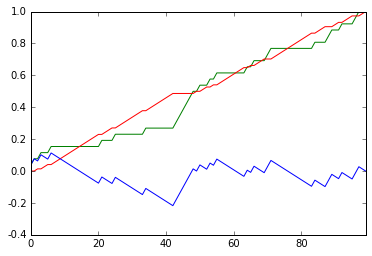

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
predict = np.random.rand(100)
actual = np.random.binomial(1,0.3,size = 100)
amount = np.random.rand(100) * 1000
data = pd.DataFrame({"actual":actual.T,"predict":predict.T,"amount":amount.T})
data = data.ix[:,['actual','predict','amount']]
threshold = 0.5
bins = 0 
judge(threshold, bins, data, 1)


In [5]:
def cluster_prepare(data, feature, label):
    import pandas as pd
    import numpy as np
    from sklearn.preprocessing import Normalizer
    cross = pd.crosstab(data[feature], data[label])
    # 计算频率
    cross['freq'] = cross[0] + cross[1]
    sum_1 = np.sum(cross[1])
    sum_0 = np.sum(cross[0])
    # 计算均值
    cross['mean'] = cross[1] * 1.0 / cross['freq']
    # 计算理论个数
    cross['ori_0'] = cross['freq'] * sum_0 *1.0 / (sum_0 + sum_1)
    cross['ori_1'] = cross['freq'] * sum_1 *1.0 / (sum_0 + sum_1)
    # 计算卡方值
    cross['chisq0'] = (cross[0] - cross['ori_0'])**2*1.0 / cross['ori_0']
    cross['chisq1'] = (cross[1] - cross['ori_1'])**2 *1.0 / cross['ori_1']
    cross['chisq'] = cross['chisq0'] + cross['chisq1']
    # 标准化
    nor = Normalizer()
    cross['freq'] = nor.fit_transform(cross['freq'].reshape(1,-1))[0]
    cross['chisq'] = nor.fit_transform(cross['chisq'].reshape(1,-1))[0]
    cross['mean'] = nor.fit_transform(cross['mean'].reshape(1,-1))[0]
    return cross.ix[:, ['freq', 'mean', 'chisq']]

def cluster_feature(cross , n_components):
    from sklearn.cluster import KMeans
    import pandas as pd
    print n_components
    km = KMeans(n_clusters=n_components,n_jobs = -1)
    component_n = km.fit_predict(cross)
    feature_n = list(cross.index)
    map_dic = pd.DataFrame({'component':component_n},index=feature_n).to_dict()['component']
    return map_dic

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
# 数据准备
label = np.random.binomial(1, 0.3, 1000)
feature = np.random.randint(0,20,size = 1000)
data = pd.DataFrame({'feature':feature, 'label':label})
data['feature'] = data['feature'].apply(lambda x:str(x))
feature = 'feature'
label = 'label'
# 生成聚类数据
cross = cluster_prepare(data, feature, label)
# 做聚类，生成匹配字典
dd = cluster_feature(cross, 3)
dd

3


{'0': 0,
 '1': 1,
 '10': 0,
 '11': 2,
 '12': 2,
 '13': 0,
 '14': 0,
 '15': 0,
 '16': 2,
 '17': 0,
 '18': 2,
 '19': 2,
 '2': 0,
 '3': 2,
 '4': 0,
 '5': 2,
 '6': 0,
 '7': 0,
 '8': 2,
 '9': 2}

In [4]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=n_components,n_jobs = -1)

In [77]:

dd

3


{'0': 0,
 '1': 0,
 '10': 0,
 '11': 0,
 '12': 0,
 '13': 1,
 '14': 1,
 '15': 0,
 '16': 2,
 '17': 0,
 '18': 0,
 '19': 0,
 '2': 0,
 '3': 2,
 '4': 2,
 '5': 0,
 '6': 0,
 '7': 0,
 '8': 0,
 '9': 0}

In [50]:
agg_clus.fit_predict(cross)

array([0, 0, 0, 0, 0, 1, 1, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0])

In [35]:
agg_clus.fit_predict(cross)

array([1, 0, 1, 0, 2, 0, 0, 0, 1, 2, 0, 1, 0, 1, 0, 0, 1, 2, 0, 0])

In [4]:
import pandas as pd
path="e:/yeepay_pay_order.csv"
reader = pd.read_csv(path, iterator=True)
chunkSize = 10
chunks = []
for i in range(10000):
    chunk = reader.get_chunk(chunkSize)
    chunks.append(chunk)
df = pd.concat(chunks, ignore_index=True)
data=pd.DataFrame(df)
data.head()

,rownum,ID,PAY_ID,GOODS_CD,CRD_TYP,BNK_ID,USE_TOOL,USR_ID,MEC_LEV,USR_TYP,...,ETLTASKID,BIZ,USE_CHANNEL,VIRTUAL_TERMID,ORDER_TYPE,BANK_ERROR,BANK_MSG,RMK,COMPLAIN_DATE,COMPLAIN_FLAG
0,831943,252155144,1.016071e+17,7993,DEBIT,ICBC,ncpayapi,2.112759e+11,NaN,YEEPAY,...,risk111_2016-07-06 15:00:00,ZHGT,NaN,null,SALE,NaN,NaN,NaN,NaN,0
1,831944,252155146,1.016071e+17,7993,CREDIT,CCB,ncpayapi,2.112749e+11,NaN,YEEPAY,...,risk111_2016-07-06 15:00:00,ZHGT,NaN,null,SALE,NaN,NaN,NaN,NaN,0
2,831945,252155243,1.016071e+17,7993,CREDIT,PSBC,ncpayapi,2.112766e+11,NaN,YEEPAY,...,risk111_2016-07-06 15:00:00,ZHGT,NaN,null,SALE,NaN,NaN,NaN,NaN,0
3,831946,252155248,1.016071e+17,7993,DEBIT,CCB,ncpayapi,2.112446e+11,NaN,YEEPAY,...,risk111_2016-07-06 15:00:00,ZHGT,NaN,null,SALE,YOCCBS_E7102,账户余额不足,NaN,NaN,0
4,831947,252155404,1.016071e+17,7993,DEBIT,ICBC,ncpayapi,2.112779e+11,NaN,YEEPAY,...,risk111_2016-07-06 15:00:00,ZHGT,NaN,null,SALE,NaN,NaN,NaN,NaN,0
